In [1]:
import sys
sys.path.append('/home/npopkov/dll24')

import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True

import numpy as np
import lightning as lt
torch.set_float32_matmul_precision('medium')
import soundfile as sf

from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

from torch.utils.data import DataLoader,Dataset

import h5py
from tqdm.auto import tqdm

class SnippetDatasetHDF(Dataset):
    def __init__(self, hdf, scaling='minmax'):
        self.num_rows = 0
        self.size = 2**15
        self.scaling = scaling
        self.data = self.createData(hdf)
        
        if scaling == 'standard':
            self.mean = self.data.mean()
            self.std =  self.data.std()
            self.data = (self.data - self.mean) / self.std
        
        if scaling == 'minmax':
            self.min = self.data.min()
            self.max = self.data.max()
            self.data = (self.data - self.min) / (self.max - self.min)
    
    def __len__(self):
        return self.num_rows
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def createData(self, hdf):
        data = []
        keys = list(hdf.keys())
        self.num_rows = len(keys)
        for key in tqdm(keys):
            sample = hdf[key]['audio'][:]
            if len(sample) > self.size:
                self.num_rows -= 1
                continue

            if len(sample) < self.size:
                sample = np.pad(sample, (0, self.size - len(sample)), 'constant')

            data.append(sample)
         
        return torch.tensor(np.array(data)).float()

    def retransform(self, data):
        if self.scaling == 'standard':
            return data * self.std + self.mean
        if self.scaling == 'minmax':
            return data * (self.max - self.min) + self.min

hdf = h5py.File('../test.hdf5', 'r')
dataset = SnippetDatasetHDF(hdf)
hdf.close()



  0%|          | 0/6675 [00:00<?, ?it/s]

In [2]:
from models.ddpm.DDPMBase import DDPMBase
from models.ddpm.oneDCAUnet import oneDCAUnet


n_steps, betaMin, betaMax = 200, 10**-6, 0.002

network = oneDCAUnet(n_steps=n_steps,
                 c_in=1,
                 c_out=1,).to('cuda')

model = DDPMBase(network=network,
                betaMin=betaMin,
                betaMax=betaMax,
                n_steps=n_steps).to('cuda')

In [3]:

# from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

# model = DiffusionModel(
#     net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
#     in_channels=1, # U-Net: number of input/output (audio) channels
#     channels=[8, 32, 64, 128, 256, 512, 512, 1024, 1024], # U-Net: channels at each layer
#     factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
#     items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
#     attentions=[0, 0, 0, 1, 1, 1, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
#     attention_heads=8, # U-Net: number of attention heads per attention item
#     attention_features=64, # U-Net: number of attention features per attention item
#     diffusion_t=VDiffusion, # The diffusion method used
#     sampler_t=VSampler, # The diffusion sampler used
# )

In [4]:
class Lightningwrapper(lt.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        loss = self.model(batch.unsqueeze(1))
        self.log('train_loss', loss)
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=3e-4)

#lt_model = Lightningwrapper(model)
dataloader = DataLoader(dataset, batch_size=64,num_workers=30)
# Train model with audio waveforms
trainer = lt.Trainer(max_epochs=40)
trainer.fit(model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2024-08-21 11:34:20.507618: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 11:34:20.514100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 11:34:20.520858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 11:34:20.522836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 11:34:20.528671: I tensorflow/core/platform/cpu_feature_guar

Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 GiB. GPU 0 has a total capacty of 23.65 GiB of which 17.48 GiB is free. Including non-PyTorch memory, this process has 6.15 GiB memory in use. Of the allocated memory 5.17 GiB is allocated by PyTorch, and 533.68 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Turn noise into new audio sample with diffusion
noise = torch.randn(1, 1, 2**15) # [batch_size, in_channels, length]
pred = model.sample(noise, num_steps=100) # Suggested num_steps 10-100
retransformed_pred = dataset.retransform(pred)
samplerate = 32000

In [ ]:
real_sample = dataset.retransform(dataset.data[0])

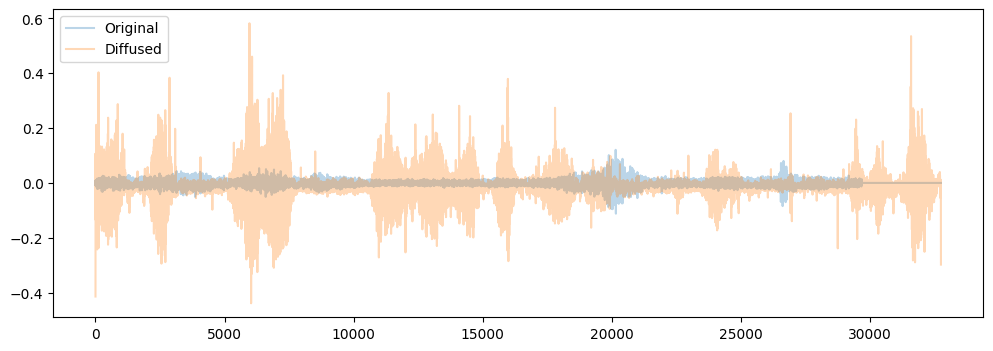

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(real_sample.cpu().numpy(), alpha=0.3, label='Original')
plt.plot(retransformed_pred[0, 0].cpu().numpy(), alpha=0.3, label='Diffused')
plt.legend()

In [ ]:
from IPython.display import Audio
Audio(retransformed_pred[0,0], rate=samplerate)


In [ ]:

Audio(real_sample, rate=samplerate)
